In [ ]:
import numpy as np
import polars as pl
import pandas as pd
from sklearn.base import clone
from copy import deepcopy
import optuna
from scipy.optimize import minimize
import os
import matplotlib.pyplot as plt
import seaborn as sns

import re
from colorama import Fore, Style

from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import *
from sklearn.metrics import *

n_splits = 5
SEED = 42

# Data Loading

## Load tabular dataset

In [ ]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

In [ ]:
train.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
count,3960.000000,3960.000000,2421.000000,3022.000000,3027.000000,3076.000000,898.000000,2954.000000,2967.000000,2954.000000,743.000000,740.000000,740.000000,2322.000000,2282.000000,1074.000000,1062.000000,1074.000000,1063.000000,2310.000000,2271.000000,2305.000000,2267.000000,2307.000000,2269.000000,2324.000000,2285.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.00000,1991.000000,1991.000000,1991.000000,475.000000,1721.000000,2733.000000,2734.000000,2731.000000,2731.000000,2729.000000,2732.000000,2729.000000,2730.000000,2730.000000,2733.000000,2734.000000,2731.000000,2729.000000,2732.000000,2730.000000,2728.000000,2725.000000,2728.000000,2730.000000,2733.000000,2736.000000,2609.000000,2606.000000,3301.000000,2736.000000
mean,10.433586,0.372727,65.454771,19.331929,55.946713,89.038615,27.278508,69.648951,81.597236,116.983074,4.989233,7.370270,27.581081,11.259690,0.476337,22.420438,1.829567,23.518622,1.904045,5.579654,0.330251,8.694924,0.618880,8.805635,0.620097,9.252775,0.785558,2.651431,6.719826,19.367048,1237.018187,2064.693747,20.825346,74.021708,15.030554,4.336495,16.855020,1.745354,33.173380,20.02299,67.301883,34.389466,53.998726,2.178853,2.589550,2.370655,2.177762,2.399854,0.839253,2.297545,1.063690,0.586295,1.246520,1.062637,1.304793,1.685443,0.244599,1.340051,1.035505,1.499634,1.452346,1.627890,1.613636,1.158974,0.943652,27.896199,41.088923,57.763622,1.060588,0.580409
std,3.574648,0.483591,22.341862,5.113934,7.473764,44.569040,5.567287,13.611226,13.665196,17.061225,2.014072,3.189662,17.707751,11.807781,0.499549,10.833995,0.612585,11.148951,0.612344,7.390161,0.470407,3.429301,0.485769,3.422167,0.485469,2.988863,0.410525,1.028267,92.586325,5.047848,1872.383246,2836.246272,73.266287,199.433753,5.792505,6.356402,199.372119,0.680635,56.272346,70.21561,108.705918,84.050607,129.362539,0.849476,0.783937,1.673312,1.697117,1.588807,1.195601,1.705218,1.268282,1.049355,1.342582,1.258797,1.331715,1.543074,0.522956,1.411156,1.301712,1.492929,1.495600,1.445622,1.529178,1.343661,1.185460,20.338853,10.427433,13.196091,1.094875,0.771122
min,5.000000,0.000000,25.000000,0.000000,33.000000,0.000000,18.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-7.789610,0.048267,813.397000,1073.450000,1.789450,28.900400,7.864850,-194.163000,-8745.080000,1.000000,14.489000,4.63581,23.620100,4.655730,20.589200,0.660000,0.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,38.000000,0.000000,0.000000
25%,8.000000,0.000000,59.000000,15.869350,50.000000,57.200000

In [ ]:
train['id'].head()

0    00008ff9
1    000fd460
2    00105258
3    00115b9f
4    0016bb22
Name: id, dtype: object

## Load timeseries data

1. **process_file**: This function process file timeseries, extract general information in the file like count, mean, std, min, 25%, 50%, 75% and max of each features and then the features matrix is flattened to a vector to represent the data in the file
2. **load_time_series** Format and load all timeseries files after processed in a folder.

In [ ]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))

    stats, indexes = zip(*results)

    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes

    return df

In [ ]:
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

100%|██████████| 2/2 [00:00<00:00,  6.99it/s]


In [ ]:
train_ts.head(5)

,Stat_0,Stat_1,Stat_2,Stat_3,Stat_4,Stat_5,Stat_6,Stat_7,Stat_8,Stat_9,Stat_10,Stat_11,Stat_12,Stat_13,Stat_14,Stat_15,Stat_16,Stat_17,Stat_18,Stat_19,Stat_20,Stat_21,Stat_22,Stat_23,Stat_24,Stat_25,Stat_26,Stat_27,Stat_28,Stat_29,Stat_30,Stat_31,Stat_32,Stat_33,Stat_34,Stat_35,Stat_36,Stat_37,Stat_38,Stat_39,Stat_40,Stat_41,Stat_42,Stat_43,Stat_44,Stat_45,Stat_46,Stat_47,Stat_48,Stat_49,Stat_50,Stat_51,Stat_52,Stat_53,Stat_54,Stat_55,Stat_56,Stat_57,Stat_58,Stat_59,Stat_60,Stat_61,Stat_62,Stat_63,Stat_64,Stat_65,Stat_66,Stat_67,Stat_68,Stat_69,Stat_70,Stat_71,Stat_72,Stat_73,Stat_74,Stat_75,Stat_76,Stat_77,Stat_78,Stat_79,Stat_80,Stat_81,Stat_82,Stat_83,Stat_84,Stat_85,Stat_86,Stat_87,Stat_88,Stat_89,Stat_90,Stat_91,Stat_92,Stat_93,Stat_94,Stat_95,id
0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,-0.054638,-0.163923,-0.114302,0.045252,-7.805897,0.000000,46.009533,4027.514893,5.415475e+13,4.438860,2.000000,30.202068,0.633126,0.513286,0.500372,0.132576,34.917873,0.000000,205.862213,108.451317,1.876976e+13,1.825557,0.000000,11.773107,-1.812031,-2.631380,-1.798073,0.0,-89.987045,0.0,0.0,3829.000000,0.000000e+00,1.0,2.0,15.0,-0.701660,-0.619076,-0.536432,0.007953,-32.948602,0.0,2.520257,3958.000000,4.325125e+13,3.0,2.0,17.0,0.015846,-0.141810,-0.104193,0.019257,-6.358004,0.0,8.230733,4029.0,5.630500e+13,5.0,2.0,28.0,0.437897,0.148919,0.223770,0.036048,13.095750,0.0,24.750000,4146.0,6.978000e+13,6.0,2.0,38.0,1.850391,3.580182,1.738203,5.314874,89.422226,0.0,2626.199951,4187.0,8.639500e+13,7.0,2.0,57.0,0745c390
1,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,0.113277,0.093139,-0.106038,0.028960,-6.065619,0.046508,56.437958,3829.466064,4.331149e+13,3.840885,2.000000,232.909103,0.507897,0.541129,0.603787,0.096825,44.034721,0.208482,206.625092,167.600983,2.509136e+13,1.957999,0.000000,5.701968,-1.807955,-2.887664,-1.004992,0.0,-89.654587,0.0,0.0,3098.166748,0.000000e+00,1.0,2.0,223.0,-0.231743,-0.257600,-0.595426,0.000367,-37.326844,0.0,4.000000,3724.000000,2.128500e+13,2.0,2.0,228.0,0.094074,0.068143,-0.228500,0.005257,-13.454103,0.0,10.050480,3812.0,4.360500e+13,4.0,2.0,233.0,0.517859,0.542323,0.312333,0.020598,18.462269,0.0,27.490936,3958.0,6.511000e+13,5.0,2.0,238.0,1.928769,3.234613,2.475326,3.966906,89.080330,1.0,2628.199951,4146.0,8.639500e+13,7.0,2.0,243.0,eaab7a96
2,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,-0.499738,0.046381,-0.181152,0.056544,-11.934993,0.000000,77.305130,4106.425781,4.481677e+13,3.148264,3.000000,100.144516,0.454021,0.510668,0.412588,0.140594,27.367514,0.000000,274.848145,50.734318,2.038156e+13,1.169176,0.000000,5.653936,-1.903281,-3.150104,-1.020313,0.0,-89.540176,0.0,0.0,3853.000000,4.500000e+10,1.0,3.0,97.0,-0.873151,-0.255299,-0.485521,0.005643,-30.154542,0.0,2.918126,4089.625000,2.888500e+13,3.0,3.0,98.0,-0.644505,0.088542,-0.191693,0.018467,-11.570901,0.0,7.863636,4111.0,4.727000e+13,3.0,3.0,99.0,-0.242422,0.381953,0.088555,0.048282,5.009753,0.0,21.022933,4140.0,6.094500e+13,4.0,3.0,100.0,1.021510,1.016589,1.746797,5.066334,86.987267,0.0,2618.199951,4183.0,8.636500e+13,7.0,3.0,134.0,8ec2cc63
3,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,0.007430,0.007583,-0.196510,0.053544,-12.847143,0.000000,9.369678,3958.604492,4.836642e+13,4.273992,2.303057,60.025017,0.586100,0.542189,0.474437,0.103401,32.552841,0.000000,54.104408,122.706802,1.868773e+13,2.023705,1.487018,7.396456,-1.684624,-2.405738,-1.023798,0.0,-89.968369,0.0,0.0,3468.000000,0.000000e+00,1.0,1.0,48.0,-0.530198,-0.412805,-0.556091,0.009947,-34.965618,0.0,0.893617,3841.000000,3.526000e+13,3.0,1.0,53.0,0.022344,0.009674,-0.245181,0.027653,-15.000056,0.0,2.340206,3947.0,4.881000e+13,4.0,1.0,60.0,0.536801,0.443383,0.084469,0.057278,4.816339,0.0,6.200000,4064.0,6.330000e+13,6.0,4.0,67.0,5.908000,2.083693,1.269051,6.134459,89

After that, we encode time series data using an autoencoder, This autoencoder encode the timeseries general features to a compact vector that contain most important information about the file.

+ **AutoEncoder**:define AutoEncoder mode.

+ **perform_autoencoder**: train the AutoEncoder model and then return the encoded featuresures
ures

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim*3),
            nn.LeakyReLU(0.2),
            nn.Linear(encoding_dim*3, encoding_dim*2),
            nn.LeakyReLU(0.2),
            nn.Linear(encoding_dim*2, encoding_dim),
            nn.LeakyReLU(0.2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim*2),
            nn.LeakyReLU(0.2),
            nn.Linear(input_dim*2, input_dim*3),
            nn.LeakyReLU(0.2),
            nn.Linear(input_dim*3, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    data_tensor = torch.FloatTensor(df_scaled)

    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)

    criterion = F.smooth_l1_loss
    optimizer = optim.Adam(autoencoder.parameters())

    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i : i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')

    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()

    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])

    return df_encoded

In [ ]:
df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

train_ts_encoded = perform_autoencoder(df_train, encoding_dim=60, epochs=100, batch_size=32)
test_ts_encoded = perform_autoencoder(df_test, encoding_dim=60, epochs=100, batch_size=32)

time_series_cols = train_ts_encoded.columns.tolist()

train_ts_encoded["id"] = train_ts["id"]
test_ts_encoded["id"] = test_ts["id"]
train_ts = train_ts_encoded
test_ts = test_ts_encoded

Epoch [10/100], Loss: 0.4826]
Epoch [20/100], Loss: 0.4662]
Epoch [30/100], Loss: 0.4570]
Epoch [40/100], Loss: 0.4534]
Epoch [50/100], Loss: 0.4537]
Epoch [60/100], Loss: 0.4521]
Epoch [70/100], Loss: 0.4399]
Epoch [80/100], Loss: 0.4395]
Epoch [90/100], Loss: 0.4385]
Epoch [100/100], Loss: 0.4356]
Epoch [10/100], Loss: 0.4276]
Epoch [20/100], Loss: 0.2135]
Epoch [30/100], Loss: 0.2135]
Epoch [40/100], Loss: 0.2135]
Epoch [50/100], Loss: 0.2135]
Epoch [60/100], Loss: 0.2135]
Epoch [70/100], Loss: 0.2135]
Epoch [80/100], Loss: 0.2135]
Epoch [90/100], Loss: 0.2135]
Epoch [100/100], Loss: 0.2135]


Time series data is then merged to the tabular data

In [ ]:
train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

Drop id because we dont take it as a feature.

In [ ]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [ ]:
train.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,Enc_1,Enc_2,Enc_3,Enc_4,Enc_5,Enc_6,Enc_7,Enc_8,Enc_9,Enc_10,Enc_11,Enc_12,Enc_13,Enc_14,Enc_15,Enc_16,Enc_17,Enc_18,Enc_19,Enc_20,Enc_21,Enc_22,Enc_23,Enc_24,Enc_25,Enc_26,Enc_27,Enc_28,Enc_29,Enc_30,Enc_31,Enc_32,Enc_33,Enc_34,Enc_35,Enc_36,Enc_37,Enc_38,Enc_39,Enc_40,Enc_41,Enc_42,Enc_43,Enc_44,Enc_45,Enc_46,Enc_47,Enc_48,Enc_49,Enc_50,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,

# Data Filtering

Select the columns which is present in test data to train

In [ ]:
featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]

Drop the NaN sii value

In [ ]:
train = train.dropna(subset='sii')

Fill the missing categorical data with "Missing"

In [ ]:
cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season',
          'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    for c in cat_c:
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df

train = update(train)
test = update(test)

Create a mapping from string to integer to push data to the model (Use one hot encode instead)

In [ ]:
def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping_train = create_mapping(col, train)
    mapping_test = create_mapping(col, test)

    train[col] = train[col].replace(mapping_train).astype(int)
    test[col] = test[col].replace(mapping_test).astype(int)

print(f'Train Shape : {train.shape} || Test Shape : {test.shape}')

Train Shape : (2736, 119) || Test Shape : (20, 118)


Some features are combined to create new features, these features may make model learn better representation of the data

In [ ]:
def feature_engineering(df):
    season_cols = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_cols, axis=1)

    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']

    drop_cols = ['FGC-FGC_GSND', 'FGC-FGC_SRL', 'Fitness_Endurance-Max_Stage', 'Physical-Waist_Circumference', 'Physical-BMI', 'BIA-BIA_BMI']
    df = df.drop(drop_cols, axis=1)
    return df

In [ ]:
train = feature_engineering(train)
test = feature_engineering(test)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Columns: 117 entries, Basic_Demos-Age to ICW_TBW
dtypes: float32(60), float64(55), int64(2)
memory usage: 13.7 KB


In [ ]:
train.head()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,Enc_1,Enc_2,Enc_3,Enc_4,Enc_5,Enc_6,Enc_7,Enc_8,Enc_9,Enc_10,Enc_11,Enc_12,Enc_13,Enc_14,Enc_15,Enc_16,Enc_17,Enc_18,Enc_19,Enc_20,Enc_21,Enc_22,Enc_23,Enc_24,Enc_25,Enc_26,Enc_27,Enc_28,Enc_29,Enc_30,Enc_31,Enc_32,Enc_33,Enc_34,Enc_35,Enc_36,Enc_37,Enc_38,Enc_39,Enc_40,Enc_41,Enc_42,Enc_43,Enc_44,Enc_45,Enc_46,Enc_47,Enc_48,Enc_49,Enc_50,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60,BMI_Age,Internet_Hours_Age,BMI_Internet_Hours,BFP_BMI,FFMI_BFP,FMI_BFP,LST_TBW,BFP_BMR,BFP_DEE,BMR_Weight,DEE_Weight,SMM_Height,Muscle_to_Fat,Hydration_Status,ICW_TBW
0,5,0,51.0,46.0,50.8,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,6.0,0.0,6.0,1.0,2.0,2.66855,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.386578,15.0,50.631947,0.545865,1.499679,0.332267,1.190475,8591.822097,13746.944840,18.356260,29.370079,0.424811,6.383063,0.643522,0.747453
1,9,0,NaN,48.0,46.0,75.0,70.0,122.0,NaN,NaN,3.0,0.0,NaN,NaN,NaN,5.0,0.0,1.0,11.0,1.0,3.0,0.0,2.0,2.57949,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,2.340,46.0,64.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126.320313,0.0,0.000000,0.282883,3.229888,0.305154,1.458119,3719.320478,5950.914352,20.362087,32.579348,0.321056,12.718037,0.588157,0.777492
2,10,1,71.0,56.5,75.6,65.0,94.0,117.0,7.0,33.0,20.0,1.0,1.0,14.7,2.0,7.0,1.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.170,38.0,54.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,166.486961,20.0,33.297392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,0,71.0,56.0,81.6,60.0,97.0,117.0,9.0,37.0,18.0,1.0,NaN,NaN,NaN,5.0,0.0,0.0,7.0,0.0,7.0,1.0,3.0,3.84191,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,2.451,31.0,45.0,0.0,1.0,-0.157397,1.545155,-0.096444,0.181024,3.641510,-0.916270,-0.007444,-0.743077,3.721524,-0.074774,-1.011378,-0.682988,-0.324059,0.075755,-0.360649,-0.758839,4.853685,0.914822,4.007440,-0.960609,4.610689,0.073760,-0.167726,0.146369,3.590505,3.194709,0.029157,-0.936764,-0.004015,0.587968,2.686907,-0.167976,-0.16855,-0.347157,4.188773,2.278828,0.895587,-0.389633,1.655055,2.175144,0.025716,-0.309118,4.979134,-1.274034,2.121059,2.053574,4.744851,-1.101642,-0.156000,1.256084,0.762714,-0.857709,-0.536480,3.871356,1.320993,0.417669,-0.227872,3.767147,-0.339083,0.315734,164.631122,0.0,0.000000,1.028971,0.747651,0.224196,1.281264,21298.377749,36207.411592,13.865564,23.571569,0.472854,6.274343,0.563684,0.661008
5,13,1,50.0,59.5,112.2,60.0,73.0,102.0,NaN,NaN,12.0,0.0,2.0,17.9,2

In [ ]:
train['sii'].head()

0    2.0
1    0.0
2    0.0
3    1.0
5    1.0
Name: sii, dtype: float64

# Training Function

**quadratic_weighted_kappa**: calculate QWK value

In [ ]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')


**threshold_Rounder**: Turn the sii from PCIAT_Total to categorical

In [ ]:
def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

**evaluate_predictions**: this function evaluate the prediction of the model by first turn integer prediction values to categorical values and then calculate QWK from it and the true labels.

In [ ]:
def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)


**TrainML**: Train the model using K-Fold, The model is regression model, predict a real value represent how bad the patient was. The value may not explicitly different, so we re-define the threshold to make it split more accurate

In [ ]:
def TrainML(model_class, test_data):

    X = train.drop(['sii'], axis=1)
    y = train['sii']

    # Apply K-Fold
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    train_S = []
    test_S = []

    oof_non_rounded = np.zeros(len(y), dtype=float)
    oof_rounded = np.zeros(len(y), dtype=int)
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        # Train model
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # Round to integer values
        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)

        #Predict with test dataset
        test_preds[:, fold] = model.predict(test_data)

        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    # Using optimizer to find the best threshold
    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded),
                              method='Nelder-Mead') # Nelder-Mead | # Powell
    assert KappaOPtimizer.success, "Optimization did not converge."

    # Use the threshold retrive from the optimizer to predict again to evaluate
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    # Use the threshold retrive from the optimizer to predict test
    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)

    # Create submition
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission, model, KappaOPtimizer.x

# Create model and train the model

**TabNet Model**: A transformer-based model that can auto preprocessing data by choosing most important features to retain and drop necessary features. Because of that, this model can be intepreter easily to visualize the important features, create an adventage for error analysis. To be used in this code, the model must be in the right format of sklearn. There are some class to do it:
+ **SimpleImputer**: This class is to impute missing values.
+ **BaseEstimator**: Inherit this class turn the child class to an estimator in sklearn, more information can be found [here](https://scikit-learn.org/1.5/modules/generated/sklearn.base.BaseEstimator.html)
+ **RegressorMixin**: This class is an mixin class, which add some useful function about regression to the child class, more information can be found [here](https://scikit-learn.org/1.5/modules/generated/sklearn.base.RegressorMixin.html)
+ **TabNetRegressor**: This is the raw tabnet model. For more information about config and model, please refer this [github repo](https://github.com/dreamquark-ai/tabnet)
  
**TabNetWrapper**: This class is sklearn representation of tabnet

**TabNetPretrainedModelCheckpoint**: This class purpose is to save the tabnet model

In [ ]:
!pip -q install /kaggle/input/pytorchtabnet/pytorch_tabnet-4.1.0-py3-none-any.whl

In [ ]:
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from pytorch_tabnet.callbacks import Callback
import os
import torch
from pytorch_tabnet.callbacks import Callback

class TabNetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.model = TabNetRegressor(**kwargs)
        self.kwargs = kwargs
        self.imputer = KNNImputer(n_neighbors=5)
        #self.imputer = SimpleImputer(strategy='median')
        self.best_model_path = 'best_tabnet_model.pt'

    def fit(self, X, y):
        X_imputed = self.imputer.fit_transform(X)

        if hasattr(y, 'values'):
            y = y.values

        X_train, X_valid, y_train, y_valid = train_test_split(
            X_imputed,
            y,
            test_size=0.2,
            random_state=42
        )

        # Train TabNet model
        history = self.model.fit(
            X_train=X_train,
            y_train=y_train.reshape(-1, 1),
            eval_set=[(X_valid, y_valid.reshape(-1, 1))],
            eval_name=['valid'],
            eval_metric=['mse', 'mae', 'rmse'],
            max_epochs=500,
            patience=50,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False,
            callbacks=[
                TabNetPretrainedModelCheckpoint(
                    filepath=self.best_model_path,
                    monitor='valid_mse',
                    mode='min',
                    save_best_only=True,
                    verbose=True
                )
            ]
        )

        # Load the best model
        if os.path.exists(self.best_model_path):
            self.model.load_model(self.best_model_path)
            os.remove(self.best_model_path)  # Remove temporary file

        return self

    def predict(self, X):
        X_imputed = self.imputer.transform(X)
        return self.model.predict(X_imputed).flatten()

    def __deepcopy__(self, memo):
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            setattr(result, k, deepcopy(v, memo))
        return result


TabNet_Params = {
    'n_d': 64,
    'n_a': 64,
    'n_steps': 5,
    'gamma': 1.5,
    'n_independent': 2,
    'n_shared': 2,
    'lambda_sparse': 1e-4,
    'optimizer_fn': torch.optim.Adam,
    'optimizer_params': dict(lr=1e-3, weight_decay=1e-5),
    'mask_type': 'entmax',
    'scheduler_params': dict(mode="min", patience=10, min_lr=1e-5, factor=0.5),
    'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
    'verbose': 1,
    'device_name': 'cuda' if torch.cuda.is_available() else 'cpu'
}

class TabNetPretrainedModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_loss', mode='min',
                 save_best_only=True, verbose=1):
        super().__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.verbose = verbose
        self.best = float('inf') if mode == 'min' else -float('inf')

    def on_train_begin(self, logs=None):
        self.model = self.trainer

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            return

        if (self.mode == 'min' and current < self.best) or \
           (self.mode == 'max' and current > self.best):
            if self.verbose:
                print(f'\nEpoch {epoch}: {self.monitor} improved from {self.best:.4f} to {current:.4f}')
            self.best = current
            if self.save_best_only:
                self.model.save_model(self.filepath)

In [ ]:
# Model parameters for LightGBM
Params = {
    'learning_rate': 0.05,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  # Increased from 6.59
    'lambda_l2': 0.01,  # Increased from 2.68e-06
    'device': 'gpu'

}


# XGBoost parameters
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased from 0.1
    'reg_lambda': 5,  # Increased from 1
    'random_state': SEED,
    'tree_method': 'gpu_hist',

}


CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 10,  # Increase this value
    'task_type': 'GPU'

}

In [ ]:
import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor

tabnet = TabNetWrapper(**TabNet_Params)
xgboost = XGBRegressor(**XGB_Params)
light = lgb.LGBMRegressor(**Params, verbose=-1, n_estimators=300, random_state=SEED)
cat = CatBoostRegressor(**CatBoost_Params)

voting = StackingRegressor(estimators=[
    ('lightgbm', light),
    ('xgboost', xgboost),
    ('catboost', cat),
    ('tabnet', tabnet)  # New:TabNet
])
Submission, model, threshold = TrainML(voting, test)

Training Folds: 100%|██████████| 5/5 [13:57<00:00, 167.40s/it]

Mean Train QWK --> 0.6545
Mean Validation QWK ---> 0.3777


----> || Optimized QWK SCORE ::  0.444


# Debugging

In [ ]:
X = train.drop(['sii'], axis=1)
y = train['sii']
prediction = threshold_Rounder(model.predict(X), threshold)

In [ ]:
print(len(prediction))
X['prediction'] = prediction
X['labels'] = y

2736


In [ ]:
X[y != prediction][X['labels'] == 0]

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,Enc_1,Enc_2,Enc_3,Enc_4,Enc_5,Enc_6,Enc_7,Enc_8,Enc_9,Enc_10,Enc_11,Enc_12,Enc_13,Enc_14,Enc_15,Enc_16,Enc_17,Enc_18,Enc_19,Enc_20,Enc_21,Enc_22,Enc_23,Enc_24,Enc_25,Enc_26,Enc_27,Enc_28,Enc_29,Enc_30,Enc_31,Enc_32,Enc_33,Enc_34,Enc_35,Enc_36,Enc_37,Enc_38,Enc_39,Enc_40,Enc_41,Enc_42,Enc_43,Enc_44,Enc_45,Enc_46,Enc_47,Enc_48,Enc_49,Enc_50,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60,BMI_Age,Internet_Hours_Age,BMI_Internet_Hours,BFP_BMI,FFMI_BFP,FMI_BFP,LST_TBW,BFP_BMR,BFP_DEE,BMR_Weight,DEE_Weight,SMM_Height,Muscle_to_Fat,Hydration_Status,ICW_TBW,prediction,labels
21,16,0,NaN,71.00,210.0,73.0,62.0,132.0,NaN,NaN,20.0,0.0,3.0,46.6,3.0,10.0,0.0,1.0,12.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.619,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,468.573696,48.0,87.857568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
41,10,0,NaN,59.00,99.2,79.0,88.0,109.0,NaN,NaN,1.0,0.0,2.0,19.3,2.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,2.0,4.02530,1189.42,1903.07,16.7031,68.9515,13.9265,6.10945,30.2485,2.0,30.5582,21.6902,64.9262,25.2613,47.2613,NaN,2.521,48.0,67.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.337834,20.0,40.067567,1.509708,0.460403,0.201975,1.373771,35978.170870,57565.012895,11.990121,19.184173,0.428158,4.134791,0.476424,0.646580,1,0.0
46,10,0,80.0,59.00,92.4,76.0,87.0,116.0,7.0,32.0,10.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,7.0,0.0,15.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.150,43.0,60.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186.604999,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
52,16,1,85.0,64.00,118.0,67.0,72.0,125.0,NaN,NaN,30.0,1.0,2.0,27.5,2.0,4.0,0.0,1.0,11.5,1.0,10.0,1.0,2.0,0.95738,1338.50,2007.74,28.3479,84.8304,14.5611,5.69355,33.1696,1.0,34.2929,22.1896,83.8730,41.0700,62.6408,2.130,NaN,36.0,51.0,2.0,-0.138535,0.723273,-0.310833,2.765228,0.142998,2.597882,-0.453370,0.758956,0.851435,0.633620,1.024045,2.003564,-0.245528,1.701829,1.656844,-0.377477,2.851956,1.478744,2.860402,0.861505,-0.436572,-0.015503,-0.004511,0.366810,-0.740143,2.219911,-0.415623,2.227261,-0.459993,-0.186580,-0.429416,-0.128398,1.036100,-0.112812,-0.372864,0.958496,2.435979,2.391593,-0.598239,3.227074,0.205385,2.914971,-0.082070,-0.353539,-0.086666,-0.170008,-0.136299,3.811042,1.500469,-0.099585,1.955878,-0.145533,0.007390,-0.553750,-0.015367,1.367349,0.736205,-0.469740,3.746681,1.114925,324.039063,32.0,40.504883,1.637625,0.438989,0.171650,1.338952,44397.509600,66595.932704,11.343220,17.014746,0.641719,7.213426,0.530854,0.547453,1,0.0
56,14,1,51.0,64.75,138.2,53.0,60.0,116.0,NaN,NaN,15.0,0.0,2.0,23.9,2.0,0.0,0.0,1.0,14.5,1.0,11.0,1.0,4.0,5.41636,1435.88,2728.18,33.0617,95.20

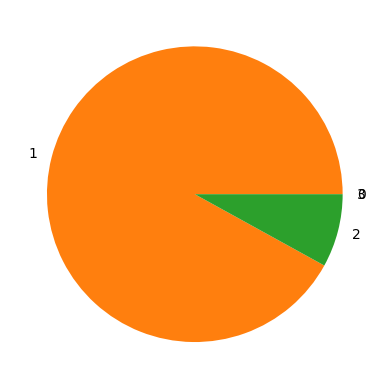

In [ ]:
import matplotlib.pyplot as plt
missing0 = X[y != prediction][X['labels'] == 0]
percentage = []
labels = []
for i in range(4):
    percentage.append(len(missing0[missing0['prediction'] == i]))
    labels.append(i)
plt.pie(percentage, labels = labels)
plt.show()

In [ ]:
type = []
labels = []
for i in range(4):
    type.append(missing0[missing0['prediction'] == i])
    labels.append(i)
type[1]

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,Enc_1,Enc_2,Enc_3,Enc_4,Enc_5,Enc_6,Enc_7,Enc_8,Enc_9,Enc_10,Enc_11,Enc_12,Enc_13,Enc_14,Enc_15,Enc_16,Enc_17,Enc_18,Enc_19,Enc_20,Enc_21,Enc_22,Enc_23,Enc_24,Enc_25,Enc_26,Enc_27,Enc_28,Enc_29,Enc_30,Enc_31,Enc_32,Enc_33,Enc_34,Enc_35,Enc_36,Enc_37,Enc_38,Enc_39,Enc_40,Enc_41,Enc_42,Enc_43,Enc_44,Enc_45,Enc_46,Enc_47,Enc_48,Enc_49,Enc_50,Enc_51,Enc_52,Enc_53,Enc_54,Enc_55,Enc_56,Enc_57,Enc_58,Enc_59,Enc_60,BMI_Age,Internet_Hours_Age,BMI_Internet_Hours,BFP_BMI,FFMI_BFP,FMI_BFP,LST_TBW,BFP_BMR,BFP_DEE,BMR_Weight,DEE_Weight,SMM_Height,Muscle_to_Fat,Hydration_Status,ICW_TBW,prediction,labels
21,16,0,NaN,71.00,210.0,73.0,62.0,132.0,NaN,NaN,20.0,0.0,3.0,46.6,3.0,10.0,0.0,1.0,12.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.619,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,468.573696,48.0,87.857568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
41,10,0,NaN,59.00,99.2,79.0,88.0,109.0,NaN,NaN,1.0,0.0,2.0,19.3,2.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,2.0,4.02530,1189.42,1903.07,16.7031,68.9515,13.9265,6.10945,30.2485,2.0,30.5582,21.6902,64.9262,25.2613,47.2613,NaN,2.521,48.0,67.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.337834,20.0,40.067567,1.509708,0.460403,0.201975,1.373771,35978.170870,57565.012895,11.990121,19.184173,0.428158,4.134791,0.476424,0.646580,1,0.0
46,10,0,80.0,59.00,92.4,76.0,87.0,116.0,7.0,32.0,10.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,7.0,0.0,15.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.150,43.0,60.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,186.604999,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0
52,16,1,85.0,64.00,118.0,67.0,72.0,125.0,NaN,NaN,30.0,1.0,2.0,27.5,2.0,4.0,0.0,1.0,11.5,1.0,10.0,1.0,2.0,0.95738,1338.50,2007.74,28.3479,84.8304,14.5611,5.69355,33.1696,1.0,34.2929,22.1896,83.8730,41.0700,62.6408,2.130,NaN,36.0,51.0,2.0,-0.138535,0.723273,-0.310833,2.765228,0.142998,2.597882,-0.453370,0.758956,0.851435,0.633620,1.024045,2.003564,-0.245528,1.701829,1.656844,-0.377477,2.851956,1.478744,2.860402,0.861505,-0.436572,-0.015503,-0.004511,0.366810,-0.740143,2.219911,-0.415623,2.227261,-0.459993,-0.186580,-0.429416,-0.128398,1.036100,-0.112812,-0.372864,0.958496,2.435979,2.391593,-0.598239,3.227074,0.205385,2.914971,-0.082070,-0.353539,-0.086666,-0.170008,-0.136299,3.811042,1.500469,-0.099585,1.955878,-0.145533,0.007390,-0.553750,-0.015367,1.367349,0.736205,-0.469740,3.746681,1.114925,324.039063,32.0,40.504883,1.637625,0.438989,0.171650,1.338952,44397.509600,66595.932704,11.343220,17.014746,0.641719,7.213426,0.530854,0.547453,1,0.0
56,14,1,51.0,64.75,138.2,53.0,60.0,116.0,NaN,NaN,15.0,0.0,2.0,23.9,2.0,0.0,0.0,1.0,14.5,1.0,11.0,1.0,4.0,5.41636,1435.88,2728.18,33.0617,95.20

(array([742., 167.,  33.,  10.,   2.,   0.,   2.,   0.,   1.,   1.]),
 array([  0. ,  11.5,  23. ,  34.5,  46. ,  57.5,  69. ,  80.5,  92. ,
        103.5, 115. ]),
 <BarContainer object of 10 artists>)

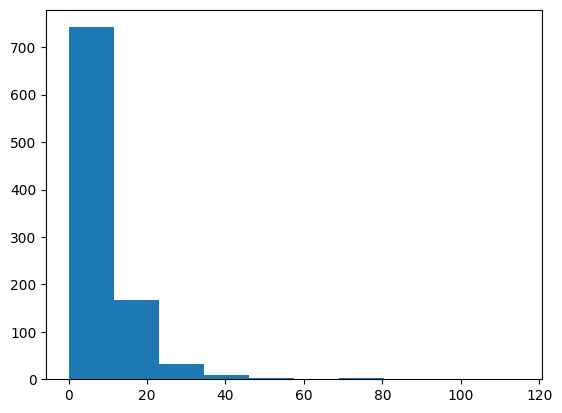

In [ ]:
plt.hist(X[X['prediction'] == 0][X['labels'] == 0]['FGC-FGC_CU'])

(array([58., 46., 39., 16., 13.,  2.,  6.,  0.,  2.,  1.]),
 array([ 0. ,  7.5, 15. , 22.5, 30. , 37.5, 45. , 52.5, 60. , 67.5, 75. ]),
 <BarContainer object of 10 artists>)

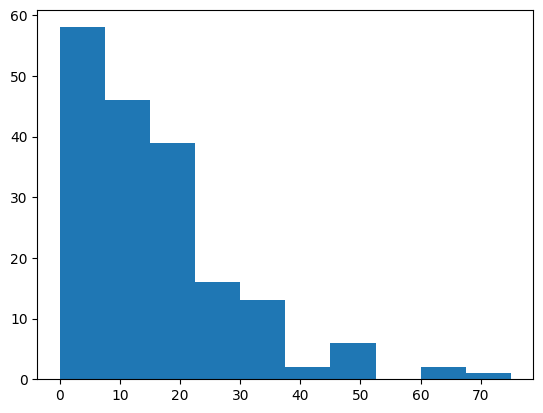

In [ ]:
plt.hist(type[1]['FGC-FGC_CU']) # Predict is 1 but true is 0

# Submit model

In [ ]:
Submission.to_csv('submission.csv', index=False)
print(Submission['sii'].value_counts())

sii
1    12
0     8
Name: count, dtype: int64
